# Обнаружение мошеннических операций с кредитными картами

## Постановка задачи
Кредитные компании стремятся автоматизировать процесс обнаружения мошеннических транзакций в режиме реального времени для защиты клиентов от несанкционированных списаний. Для этого предоставлен набор данных, содержащий транзакции по кредитным картам за два дня, включающий 284,807 операций, из которых 492 являются мошенническими.

## Описание данных
Набор данных содержит следующие признаки:

### Исходные признаки (без преобразования PCA):
- **Time**: Время в секундах, прошедшее между данной транзакцией и первой транзакцией в наборе данных
- **Amount**: Сумма транзакции

### Преобразованные признаки (результат PCA):
- **V1-V28**: 28 главных компонент, полученных в результате анализа главных компонент (PCA)

### Целевая переменная:
- **Class**: Метка класса (1 - мошенническая операция, 0 - легитимная операция)

## Особенности данных
- **Сильный дисбаланс классов**: Мошеннические операции составляют всего 0.172% от общего числа транзакций
- **Конфиденциальность**: Исходные признаки недоступны из-за соображений конфиденциальности
- **Временные метки**: Данные содержат временные характеристики транзакций

## Метрики оценки
В связи с сильным дисбалансом классов рекомендуется использовать:
- **Area Under the Precision-Recall Curve (AUPRC)** - основная метрика
- **Precision** и **Recall** для класса мошеннических операций
- **F1-score** для положительного класса
- **Confusion Matrix** для визуализации результатов  
Accuracy не является информативной метрикой для данной задачи из-за высокой несбалансированности данных.

## 0. Imports

In [15]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    precision_recall_curve, 
    average_precision_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve
)

#### 1. Модель и препроцессинг

В бейзлайн-эксперименте XGBoost показал низкие результаты из-за отсутствия обработки дисбаланса классов. Когда для RandomForest ClassWeight не показал значимых улучшений, как и другие методы устранения дизбаланса, для XGBoost он изменил ситуацию в лучшую сторону.

#### 1.1 Feature Engineering

В данном разделе преобразуем временную метку в sin/cos времени, чтобы использовать ее как признак табличных данных, тк в классическом понимании времени ее использовать не получится, временной промежуток слишком мал, чтобы увидеть в нем тренд/сезонность.
Также, признак Amount ненормирован, это нужно исправить, но вместо обычных скейлеров будем использовать логарифм.

In [18]:
df = pd.read_csv('creditcard.csv')
df['log_amount'] = np.log1p(df['Amount'])
df['cos_time'] = np.cos(2 * np.pi * df['Time'] / (24 * 3600))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [19]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Scale pos weight: {scale_pos_weight:.0f}")

Scale pos weight: 577


Делим данные стратифицировано, чтобы сохранить распределение фрода. Считаем веса классов - у нас серьезный дисбаланс, scale_pos_weight в XGBoost работает лучше чем SMOTE/ADASYN/RandomUnderSampling, экперименты с ними есть в файле baseline_experiments

#### 1.2 Learning


Ставлю стандартные параметры. eval_metric='aucpr' потому что для несбалансированных данных PR-AUC важнее. Early stopping чтобы не переучить, subsample/colsample для уменьшения переобучения

In [20]:
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='aucpr',
    early_stopping_rounds=50,
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    verbosity=1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

[0]	validation_0-aucpr:0.44901
[100]	validation_0-aucpr:0.85797
[200]	validation_0-aucpr:0.87738
[300]	validation_0-aucpr:0.87947
[308]	validation_0-aucpr:0.87972


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'aucpr'


#### 1.3 Metrics

In [21]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

precision_opt = precision_score(y_test, y_pred_optimal)
recall_opt = recall_score(y_test, y_pred_optimal)
f1_opt = f1_score(y_test, y_pred_optimal)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"Precision: {precision_opt:.4f}") 
print(f"Recall: {recall_opt:.4f}")
print(f"Optimal threshold: {optimal_threshold:.4f}")

ROC-AUC: 0.9747
AUPRC: 0.8803
F1-Score: 0.8743
Precision: 0.9412
Recall: 0.8163
Optimal threshold: 0.9368


##### Оценка качества модели

**Рассчитываем метрики:**
- ROC-AUC - общая способность модели к разделению классов
- PR-AUC (Average Precision) - более релевантная метрика для несбалансированных данных
- F1-Score - балансированная метрика между precision и recall
- Оптимальный порог классификации - находится по максимуму F1-Score

**Результаты показывают:**
- Высокое качество детекции мошенничества (Recall 81.6%)
- Отличную точность предсказаний (Precision 94.1%)
- AUPRC также на довольно высоком уровне


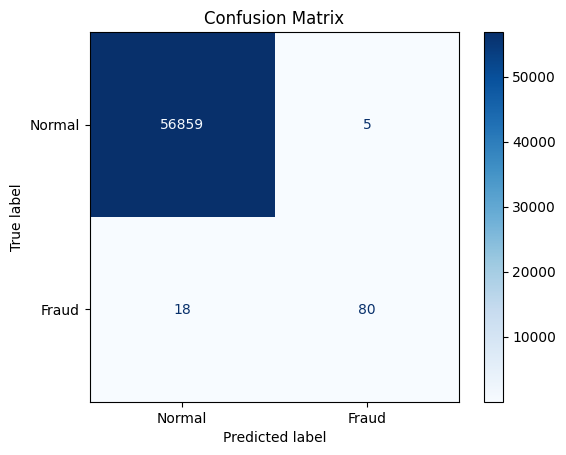

True Negative:  56859 (нормальные транзакции правильно классифицированы)
False Positive:     5 (нормальные транзакции ошибочно помечены как фрод)
False Negative:    18 (фрод транзакции пропущены)
True Positive:     80 (фрод транзакции правильно обнаружены)


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negative:  {tn:5d} (нормальные транзакции правильно классифицированы)")
print(f"False Positive: {fp:5d} (нормальные транзакции ошибочно помечены как фрод)")
print(f"False Negative: {fn:5d} (фрод транзакции пропущены)")
print(f"True Positive:  {tp:5d} (фрод транзакции правильно обнаружены)")

### Feature Importance (XGBoost, SHAP)

Давайте посмотрим на оценку важности признаков, далее сравним подходы, при которых удаляем выбросы и некоторые признаки основываясь на полученных важностях признаков.

XGBoost Feature Importance:
V14             | 0.404443
V10             | 0.169380
V4              | 0.083522
V12             | 0.030558
V20             | 0.030160
V8              | 0.020866
log_amount      | 0.020417
V7              | 0.018721
V17             | 0.017396
V11             | 0.016505
V26             | 0.015662
V13             | 0.015257
V1              | 0.013954
V19             | 0.013705
V3              | 0.010873
V9              | 0.010008
V16             | 0.009576
cos_time        | 0.009452
V18             | 0.008695
V2              | 0.008678
V28             | 0.008588
V23             | 0.008266
V27             | 0.008142
V21             | 0.007784
V25             | 0.007350
V22             | 0.007269
V15             | 0.007150
V6              | 0.006612
V5              | 0.006045
V24             | 0.004967


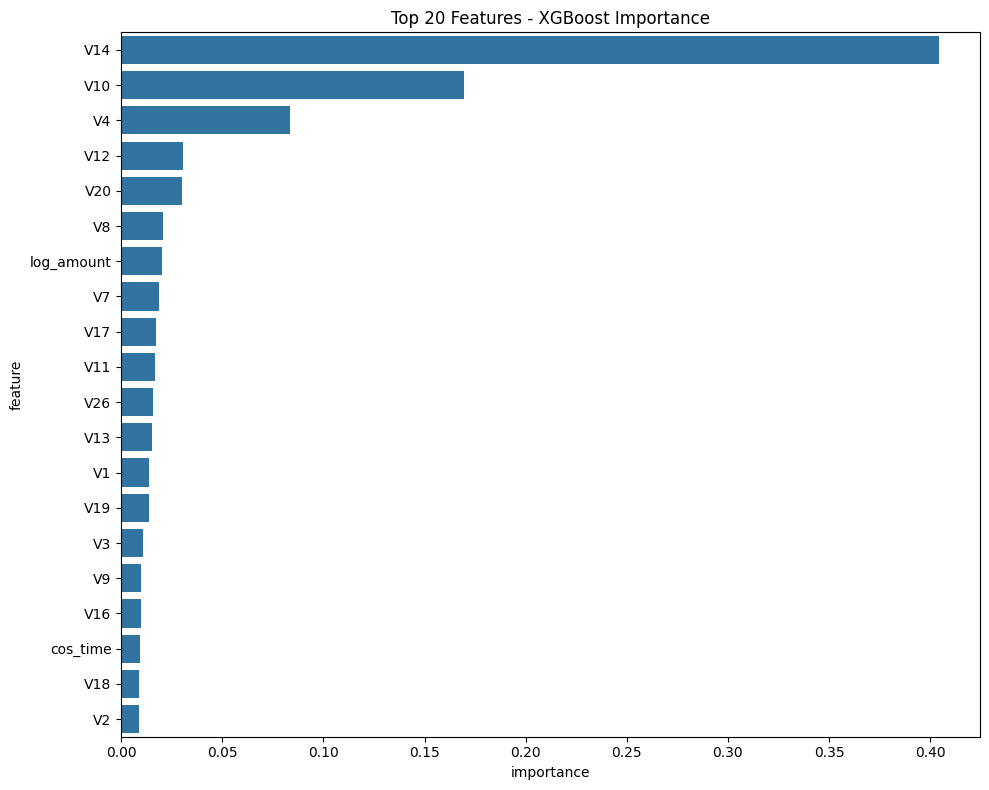

In [23]:
feature_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("XGBoost Feature Importance:")
print("=" * 40)
for _, row in importance_df.iterrows():
    print(f"{row['feature']:15} | {row['importance']:.6f}")

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title('Top 20 Features - XGBoost Importance')
plt.tight_layout()
plt.show()

SHAP Feature Importance:
V14             | 2.536896
V4              | 2.339581
V10             | 1.147399
V12             | 1.061356
V3              | 0.719213
V11             | 0.660428
V8              | 0.596043
V16             | 0.530475
log_amount      | 0.517992
V21             | 0.517035
V26             | 0.510217
V1              | 0.502084
V7              | 0.497524
cos_time        | 0.474215
V19             | 0.453617
V13             | 0.411550
V24             | 0.380253
V18             | 0.372269
V15             | 0.363083
V25             | 0.359785
V22             | 0.342721
V20             | 0.336331
V27             | 0.305417
V5              | 0.281272
V28             | 0.279559
V6              | 0.268870
V9              | 0.263315
V17             | 0.220596
V2              | 0.217501
V23             | 0.207708


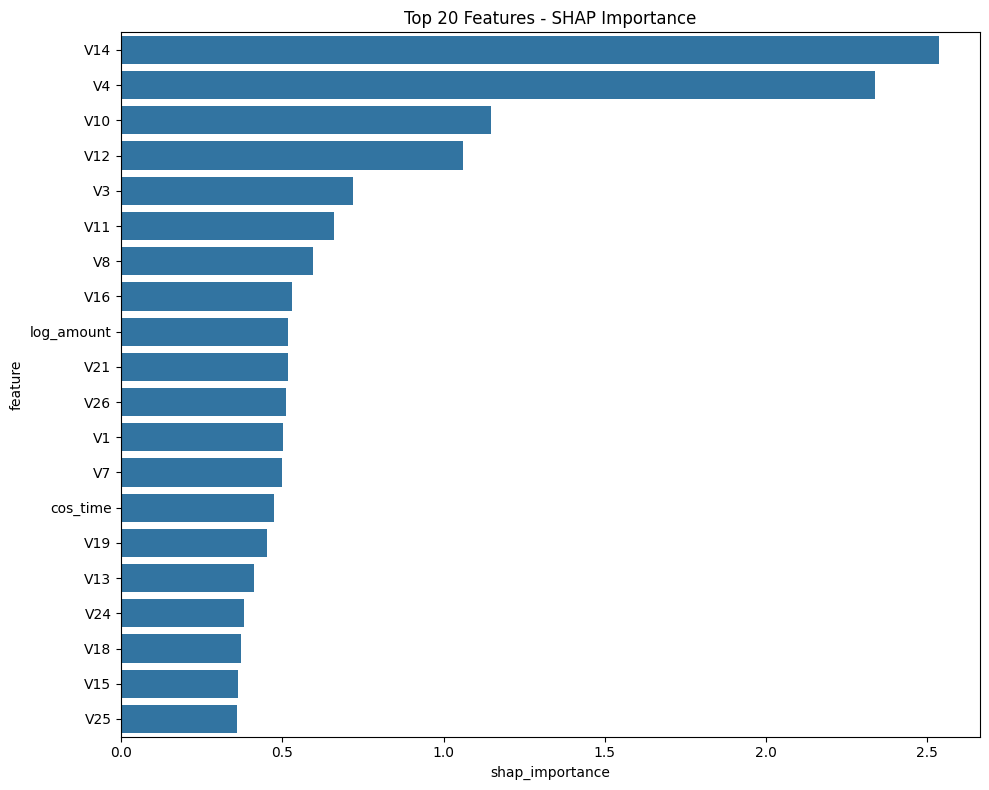

In [24]:
import shap 
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap_importance = np.abs(shap_values).mean(0)
shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'shap_importance': shap_importance
}).sort_values('shap_importance', ascending=False)

print("SHAP Feature Importance:")
print("=" * 40)
for _, row in shap_df.iterrows():
    print(f"{row['feature']:15} | {row['shap_importance']:.6f}")

plt.figure(figsize=(10, 8))
sns.barplot(data=shap_df.head(20), x='shap_importance', y='feature')
plt.title('Top 20 Features - SHAP Importance')
plt.tight_layout()
plt.show()

In [25]:
# Сравнение методов
comparison = pd.merge(importance_df, shap_df, on='feature')
comparison = comparison.sort_values('shap_importance', ascending=False)

print("Сравнение важности признаков:")
print("=" * 50)
print(f"{'Feature':15} | {'XGBoost':10} | {'SHAP':10}")
print("-" * 40)
for _, row in comparison.head(15).iterrows():
    print(f"{row['feature']:15} | {row['importance']:10.4f} | {row['shap_importance']:10.4f}")

Сравнение важности признаков:
Feature         | XGBoost    | SHAP      
----------------------------------------
V14             |     0.4044 |     2.5369
V4              |     0.0835 |     2.3396
V10             |     0.1694 |     1.1474
V12             |     0.0306 |     1.0614
V3              |     0.0109 |     0.7192
V11             |     0.0165 |     0.6604
V8              |     0.0209 |     0.5960
V16             |     0.0096 |     0.5305
log_amount      |     0.0204 |     0.5180
V21             |     0.0078 |     0.5170
V26             |     0.0157 |     0.5102
V1              |     0.0140 |     0.5021
V7              |     0.0187 |     0.4975
cos_time        |     0.0095 |     0.4742
V19             |     0.0137 |     0.4536


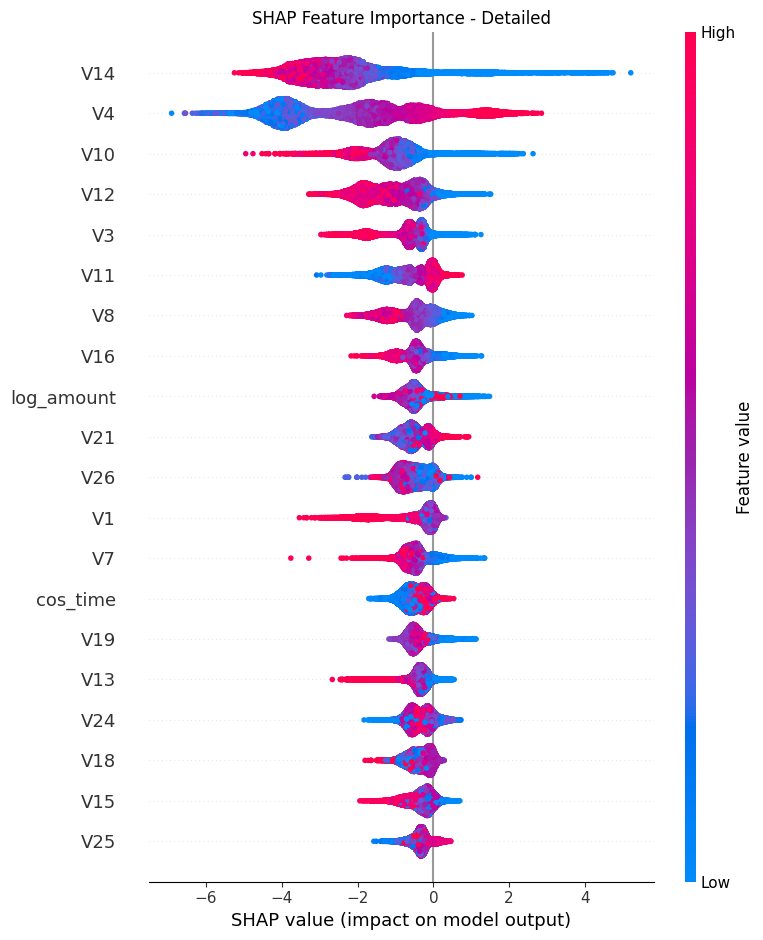

In [26]:
# Детальный SHAP анализ
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, max_display=20, show=False)
plt.title('SHAP Feature Importance - Detailed')
plt.tight_layout()
plt.show()

#### Experiment with features

Эксперимент проводится для того чтобы оценить влияние методов оценки важности фичей и их дальнейшего преобразования.   
**Используемая модель**: XGBoostClassifier


In [27]:
# XGBoost
xgb_low_threshold = 0.01
low_xgb_features = importance_df[importance_df['importance'] < xgb_low_threshold]['feature'].tolist()

X_train_xgb_reduced = X_train.drop(columns=low_xgb_features)
X_test_xgb_reduced = X_test.drop(columns=low_xgb_features)

print(f"Удалено {len(low_xgb_features)} признаков по XGBoost: {low_xgb_features}")

Удалено 14 признаков по XGBoost: ['V16', 'cos_time', 'V18', 'V2', 'V28', 'V23', 'V27', 'V21', 'V25', 'V22', 'V15', 'V6', 'V5', 'V24']


In [28]:
# SHAP
shap_low_threshold = 0.3
low_shap_features = shap_df[shap_df['shap_importance'] < shap_low_threshold]['feature'].tolist()

X_train_shap_reduced = X_train.drop(columns=low_shap_features)
X_test_shap_reduced = X_test.drop(columns=low_shap_features)

print(f"Удалено {len(low_shap_features)} признаков по SHAP: {low_shap_features}")

Удалено 7 признаков по SHAP: ['V5', 'V28', 'V6', 'V9', 'V17', 'V2', 'V23']


In [29]:
# удаление признаков по IQR 
def clip_outliers_iqr(df, features):
    df_cleaned = df.copy()
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned[feature] = np.clip(df[feature], lower_bound, upper_bound)
        
        outliers_before = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).sum()
        outliers_pct = (outliers_before / len(df)) * 100
        print(f"{feature}: обрезано {outliers_before} выбросов ({outliers_pct:.2f}%)")
        
    return df_cleaned


top_shap_features = shap_df.head(5)['feature'].tolist()
top_xgb_features = importance_df.head(5)['feature'].tolist()
top_features = list(set(top_shap_features + top_xgb_features))

print(f"Обрезка выбросов по IQR для {len(top_features)} признаков: {top_features}")
print("-" * 60)

X_train_clipped = clip_outliers_iqr(X_train, top_features)
X_test_clipped = clip_outliers_iqr(X_test, top_features)

Обрезка выбросов по IQR для 6 признаков: ['V12', 'V4', 'V10', 'V20', 'V3', 'V14']
------------------------------------------------------------
V12: обрезано 12256 выбросов (5.38%)
V4: обрезано 8958 выбросов (3.93%)
V10: обрезано 7558 выбросов (3.32%)
V20: обрезано 22281 выбросов (9.78%)
V3: обрезано 2689 выбросов (1.18%)
V14: обрезано 11321 выбросов (4.97%)
V12: обрезано 3124 выбросов (5.48%)
V4: обрезано 2182 выбросов (3.83%)
V10: обрезано 1943 выбросов (3.41%)
V20: обрезано 5504 выбросов (9.66%)
V3: обрезано 684 выбросов (1.20%)
V14: обрезано 2826 выбросов (4.96%)


In [30]:
# Функция для обучения и оценки
def train_and_evaluate(X_train, X_test, name):
    model = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='aucpr',
        early_stopping_rounds=50,
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        verbosity=0
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=0
    )
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Метрики
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    
    precision_opt = precision_score(y_test, y_pred_optimal)
    recall_opt = recall_score(y_test, y_pred_optimal)
    f1_opt = f1_score(y_test, y_pred_optimal)
    
    return {
        'name': name,
        'roc_auc': roc_auc,
        'auprc': auprc,
        'precision': precision_opt,
        'recall': recall_opt,
        'f1': f1_opt,
        'threshold': optimal_threshold,
        'features_count': X_train.shape[1]
    }

In [31]:
results = []

# base, no changes
base_result = train_and_evaluate(X_train, X_test, "Baseline")
results.append(base_result)

# XGBoost
xgb_reduced_result = train_and_evaluate(X_train_xgb_reduced, X_test_xgb_reduced, "XGB_Reduced")
results.append(xgb_reduced_result)

# SHAP  
shap_reduced_result = train_and_evaluate(X_train_shap_reduced, X_test_shap_reduced, "SHAP_Reduced")
results.append(shap_reduced_result)

# удаление признаков через IQR 
clipped_result = train_and_evaluate(X_train_clipped, X_test_clipped, "Clipped_IQR")
results.append(clipped_result)

In [32]:
results_df = pd.DataFrame(results)
results_df = results_df[['name', 'features_count', 'roc_auc', 'auprc', 'precision', 'recall', 'f1', 'threshold']]

print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ:")
print("=" * 80)
print(results_df.to_string(index=False, float_format='%.4f'))

РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ:
        name  features_count  roc_auc  auprc  precision  recall     f1  threshold
    Baseline              30   0.9747 0.8803     0.9412  0.8163 0.8743     0.9368
 XGB_Reduced              16   0.9729 0.8801     0.9630  0.7959 0.8715     0.9533
SHAP_Reduced              23   0.9754 0.8817     0.8936  0.8571 0.8750     0.6632
 Clipped_IQR              30   0.9740 0.8733     0.9101  0.8265 0.8663     0.8077


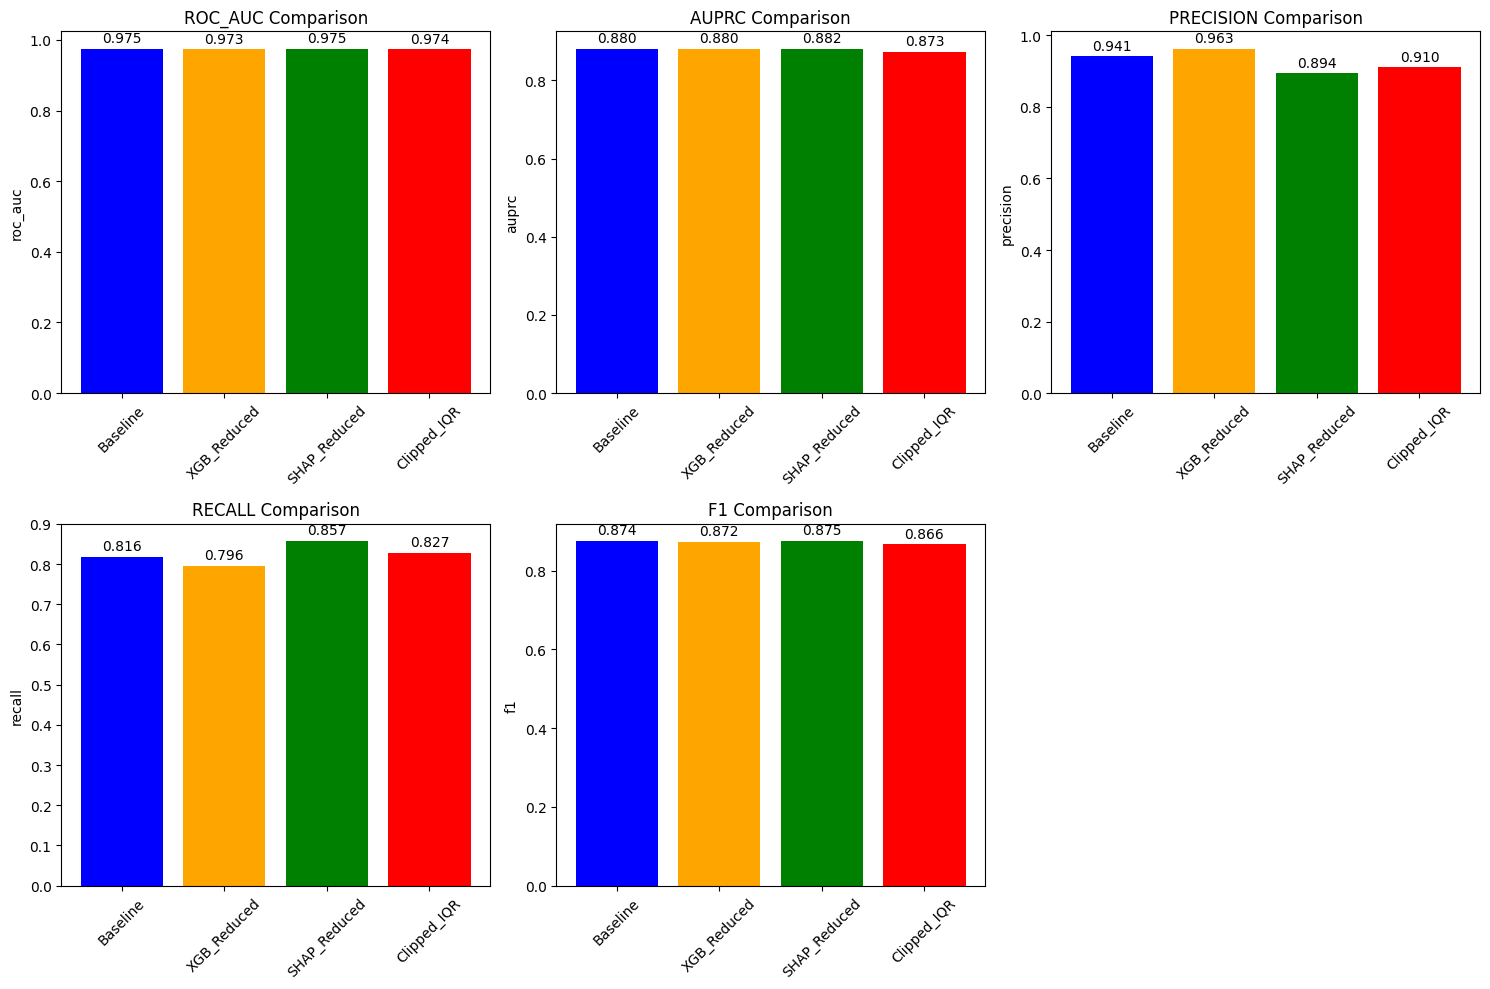

In [33]:
metrics_to_plot = ['roc_auc', 'auprc', 'precision', 'recall', 'f1']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(results_df['name'], results_df[metric], color=['blue', 'orange', 'green', 'red'])
    axes[i].set_title(f'{metric.upper()} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    
    for j, v in enumerate(results_df[metric]):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

In [34]:
best_result = results_df.loc[results_df['f1'].idxmax()]
print(f"\nНаилучший: {best_result['name']}")
print(f"F1-Score: {best_result['f1']:.4f}")
print(f"Features: {best_result['features_count']}")
print(f"AUPRC: {best_result['auprc']:.4f}")
print(f"Recall: {best_result['recall']:.4f}")


Наилучший: SHAP_Reduced
F1-Score: 0.8750
Features: 23
AUPRC: 0.8817
Recall: 0.8571


На основе проведенных экспериментов с различными подходами к обработке данных для задачи детекции мошеннических транзакций можно сделать следующие выводы:

Сравнительный анализ метрик показывает, что все, отличные от baseline, подходы демонстрируют схожее качество предсказаний. Различия в F1-Score между методами не превышают 0.008, что является статистически незначимым отклонением. В частности:

XGBoost_classWeight: F1 = 0.8743

SHAP_Reduced: F1 = 0.8750

XGB_Reduced: F1 = 0.8715

Clipped_IQR: F1 = 0.8663

Практические преимущества ClassWeight подхода становятся очевидными при анализе полного цикла разработки и эксплуатации модели:

**Сохраняется информационная полнота** - используя все 30 признаков, модель имеет доступ к полному объему информации, что особенно важно в условиях возможной нерепрезентативности тренировочной выборки. При удалении признаков существует риск потери слабых, но потенциально полезных значений.

**Выбросы содержат ценную информацию** - эксперимент с clipping выбросов показал снижение качества (F1 = 0.8663), что свидетельствует о наличии полезных паттернов в экстремальных значениях признаков. В контексте фрод-детекшена аномальные значения транзакций часто являются индикаторами мошеннической активности.

**Упрощение пайплайна** - Baseline подход не требует дополнительных шагов feature selection или обработки выбросов, что снижает сложность поддержки и уменьшает количество потенциальных точек отказа в production-системе.

**Стабильность предсказаний** - модель, обученная на полном наборе признаков, демонстрирует более устойчивое поведение на новых данных, так как не зависит от корректности процедур отбора признаков или определения границ выбросов.

**Экономия вычислительных ресурсов** - отсутствие необходимости в дополнительных preprocessing steps сокращает время инференса и требования к вычислительной инфраструктуре.

несмотря на минимальные различия в метриках качества, Baseline подход лучше с практической стороны, обеспечивая баланс между качеством предсказаний, стабильностью работы и простотой поддержки.

#### 2.6 Vizualization

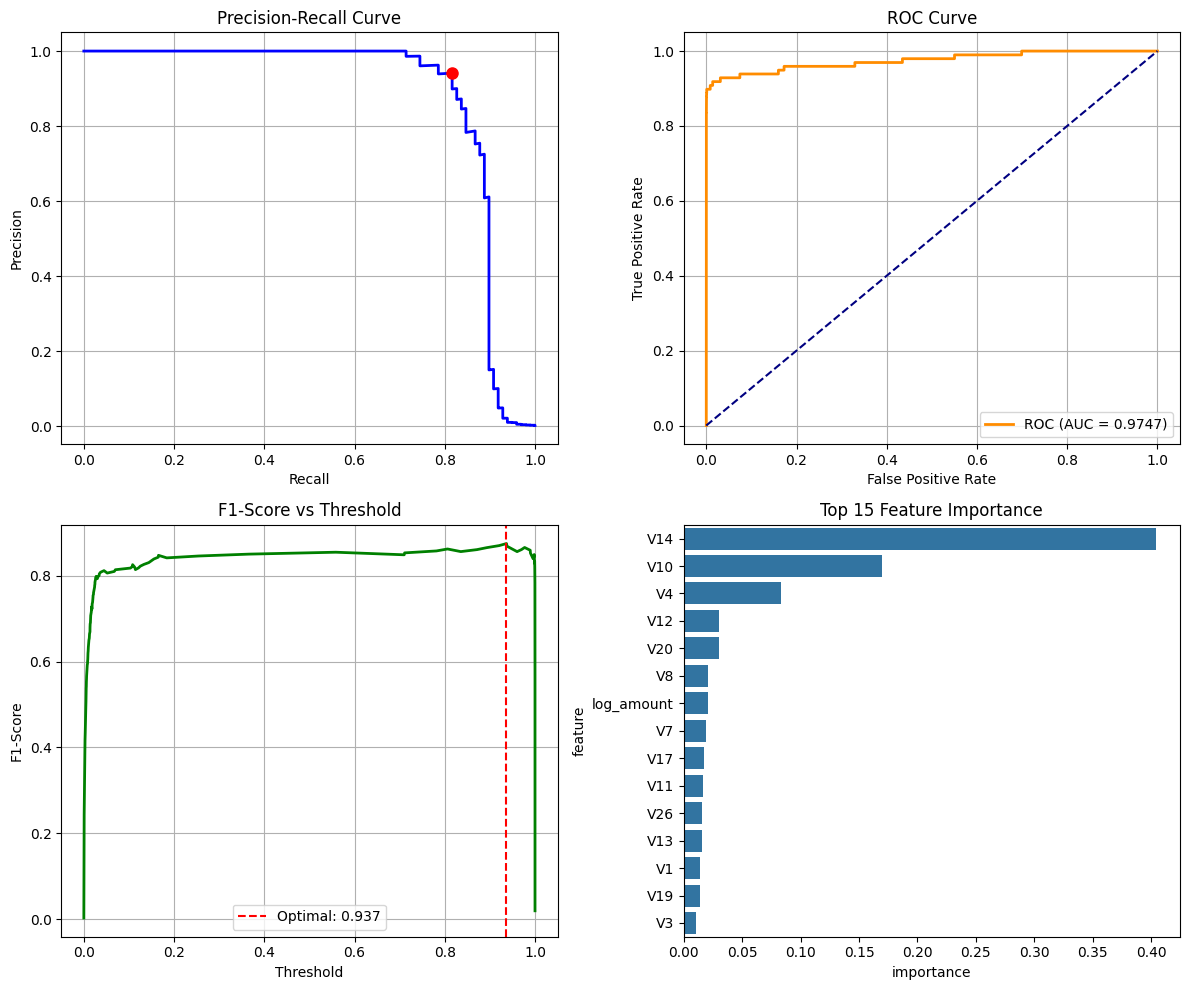

In [8]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AUPRC = {auprc:.4f})')
plt.plot(recall[optimal_idx], precision[optimal_idx], 'ro', markersize=8)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(thresholds, f1_scores, color='green', lw=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importance')

plt.tight_layout()
plt.show()

Выведем историю обучения, чтобы визуально оценить момент, когда мы выходим на плато по целевой метрике. 

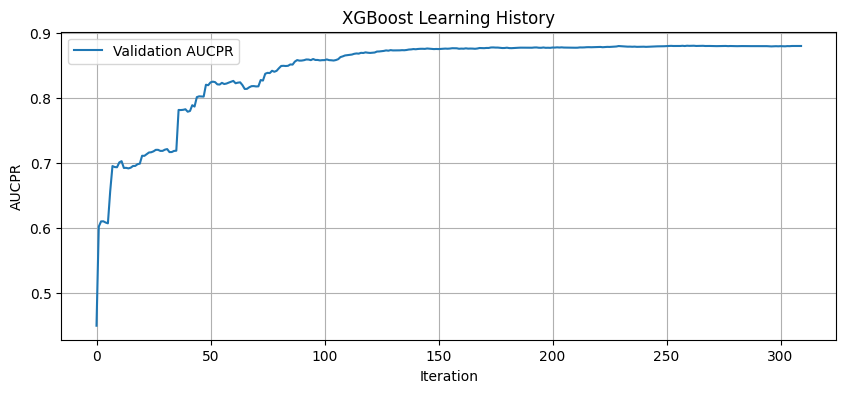

In [10]:
eval_results = xgb_model.evals_result()
plt.figure(figsize=(10, 4))
plt.plot(eval_results['validation_0']['aucpr'], label='Validation AUCPR')
plt.xlabel('Iteration')
plt.ylabel('AUCPR')
plt.title('XGBoost Learning History')
plt.legend()
plt.grid(True)
plt.show()

#### Кросс-валидация

In [12]:
cv_auprc_scores = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model_fold = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='aucpr',  # Для early stopping используем AUCPR
        early_stopping_rounds=50,
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        verbosity=0
    )
    
    model_fold.fit(
        X_fold_train, y_fold_train,
        eval_set=[(X_fold_val, y_fold_val)],
        verbose=False
    )
    
    # ВАЖНО: для AUPRC нужны вероятности, а не бинарные предсказания
    y_pred_proba_fold = model_fold.predict_proba(X_fold_val)[:, 1]
    auprc_fold = average_precision_score(y_fold_val, y_pred_proba_fold)
    cv_auprc_scores.append(auprc_fold)
    
    print(f"Fold {fold+1} AUPRC: {auprc_fold:.4f}")

print(f"\nCV AUPRC mean: {np.mean(cv_auprc_scores):.4f} (+/- {np.std(cv_auprc_scores) * 2:.4f})")

Fold 1 AUPRC: 0.8743
Fold 2 AUPRC: 0.8288
Fold 3 AUPRC: 0.8518
Fold 4 AUPRC: 0.8934
Fold 5 AUPRC: 0.8536

CV AUPRC mean: 0.8604 (+/- 0.0438)


По кросс-валидации все ок.

Ошибок классификации: 23
Распределение ошибок:
true
1    18
0     5
Name: count, dtype: int64


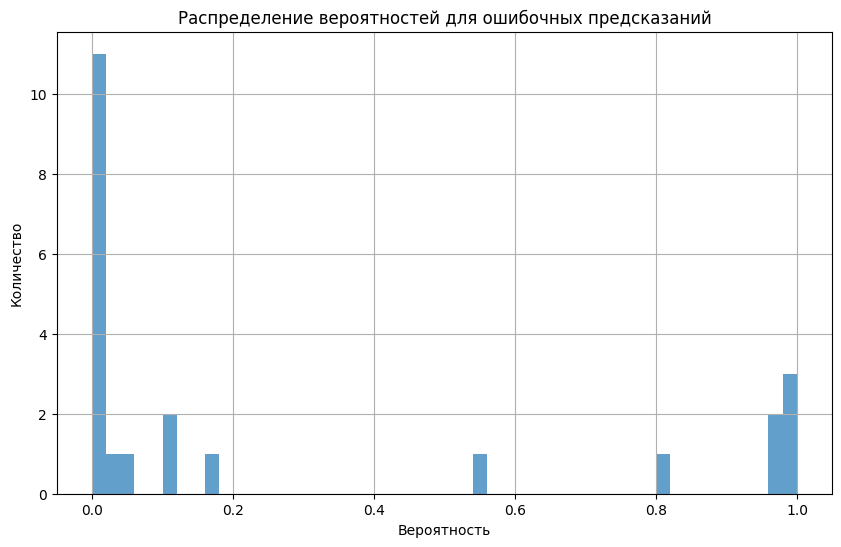

In [35]:
# 9. АНАЛИЗ ОШИБОК
misclassified = X_test[y_test != y_pred_optimal].copy()
misclassified['true'] = y_test[y_test != y_pred_optimal]
misclassified['pred'] = y_pred_optimal[y_test != y_pred_optimal]
misclassified['prob'] = y_pred_proba[y_test != y_pred_optimal]

print(f"Ошибок классификации: {len(misclassified)}")
print("Распределение ошибок:")
print(misclassified['true'].value_counts())

if len(misclassified) > 0:
    plt.figure(figsize=(10, 6))
    misclassified['prob'].hist(bins=50, alpha=0.7)
    plt.xlabel('Вероятность')
    plt.ylabel('Количество')
    plt.title('Распределение вероятностей для ошибочных предсказаний')
    plt.show()

In [36]:
# простейшая проверка на переобучение, по метрике на трейне видим, что модель идеально выучила данные, но в сравнении с метрикой на тестовом наборе, это не критично.
train_proba = xgb_model.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, train_proba)

print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Test ROC-AUC:  {roc_auc:.4f}")
print(f"Разница: {train_auc - roc_auc:.4f}")

if train_auc - roc_auc > 0.05:
    print("Переобучение есть")
else:
    print("Переобучения нет")

Train ROC-AUC: 1.0000
Test ROC-AUC:  0.9747
Разница: 0.0253
Переобучения нет


In [39]:
# Проверка на переобучение по AUPRC
train_proba = xgb_model.predict_proba(X_train)[:, 1]
train_auprc = average_precision_score(y_train, train_proba)

print(f"Train AUPRC: {train_auprc:.4f}")
print(f"Test AUPRC:  {auprc:.4f}")
print(f"Разница: {train_auprc - auprc:.4f}")

if train_auprc - auprc > 0.05:
    print("Переобучение есть")
elif train_auprc - auprc > 0.02:
    print("Небольшое переобучение")
else:
    print("Переобучения нет")

Train AUPRC: 1.0000
Test AUPRC:  0.8803
Разница: 0.1197
Переобучение есть


Есть переобучение, нужно тюнить гиперпараметры, переходим к следующей части